(4, 3060)
(3060,)


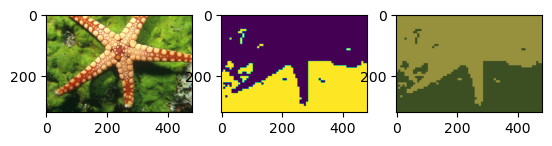

In [7]:
# CS5487 demo script for Programming Assignment 2
#
# The script has been tested with python 2.7.6
#
# It requires the following modules:
#   numpy 1.8.1
#   matplotlib v1.3.1
#   scipy 0.14.0
#   Image (python image library)

import pa2
import numpy as np
import pylab as pl
from PIL import Image
import scipy.io as sio

def demo():
    import scipy.cluster.vq as vq

    ## load and show image
    img = Image.open('images/12003.jpg')
    pl.subplot(1,3,1)
    pl.imshow(img)
    
    ## extract features from image (step size = 7)
    X,L = pa2.getfeatures(img, 7)

    print(X.shape)
    ## Call kmeans function in scipy.  You need to write this yourself!
    C,Y = vq.kmeans2(vq.whiten(X.T), 2, iter=1000, minit='random')
    Y = Y + 1 # Use matlab 1-index labeling
    print(Y.shape)
    ## 

    # make segmentation image from labels
    segm = pa2.labels2seg(Y,L)
    pl.subplot(1,3,2)
    pl.imshow(segm)
    
    # color the segmentation image
    csegm = pa2.colorsegms(segm, img)
    pl.subplot(1,3,3)
    pl.imshow(csegm)
    pl.show()

def main():
    demo()
if __name__ == '__main__':
    main()


In [10]:
from collections import Counter


point = np.loadtxt('./cluster_data_text/cluster_data_dataA_X.txt')
True_label = np.loadtxt('./cluster_data_text/cluster_data_dataA_Y.txt')
Counter(True_label)
print(point.shape)

(2, 200)


In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import scipy.cluster.vq as vq
import pa2
import numpy as np
import pylab as pl
from PIL import Image
import scipy.io as sio

In [2]:
def loadData(datafile:str, problem:str, img=None):
    if problem == 'a':
        X = np.loadtxt('./cluster_data_text/{}.txt'.format(datafile))
        return X
    else :
        ## extract features from image (step size = 7)
        X,L = pa2.getfeatures(img, 7)
        X = vq.whiten(X.T).T
        return X, L

In [3]:
def dist(X, C, i, scale=0, lbda=0):
    if scale==0:
        return np.linalg.norm(X - C[:, i].reshape(-1, 1), axis=0)**2
    else:
        return np.linalg.norm(X[:2] - C[:2, i].reshape(-1, 1) , axis=0)**2 + lbda * np.linalg.norm(X[2:4] - C[2:4, i].reshape(-1, 1) , axis=0)**2

        
def Kmeans(X, K, iter=1000, sensitivity=0.00001, scale=0, lbda=0):
    D, N = X.shape
    C = X[:, np.random.choice(N, K, replace=False)]
    Y = np.zeros(N)
    for j in range(iter):

        distance = np.zeros((K, N))
        for i in range(K):
            distance[i, :] = dist(X, C, i, scale=scale, lbda=lbda)

        Y = np.argmin(distance, axis=0)

        C_new = np.zeros((D, K))
        for i in range(K):
            C_new[:, i] = np.mean(X[:, Y == i], axis=1)

        if np.sum((C_new - C) ** 2) < sensitivity:
            break
        C = C_new
    return Y, C



In [4]:
def init_data(sample, K): 
    Pi = (1/K)*np.ones(K) 
    X = sample
    mu = np.random.random((X.shape[0], K))
    Cov_mat = np.array([np.identity(X.shape[0]) for i in range(K)])
    respon = np.zeros((X.shape[1],K))  
    return X, Pi, mu, Cov_mat, respon



def E_step(X, Pi, mu, Cov_mat, respon, K):   
    N = X.shape[1]
    for i in range(N):
        Numer = np.zeros((1,K))
        Denom = 0 
        for j in range(K):
            Numer[:,j] = Pi[j] * math.exp(-1/2 * (X[:,i] - mu[:,j]).T @ np.linalg.inv(Cov_mat[j])@(X[:,i] - mu[:,j])) / math.sqrt(2*math.pi*np.linalg.det(Cov_mat[j]))
        respon[i, :] = Numer / np.sum(Numer, axis=1) 
    return respon
    
    
def M_step(X, Pi, mu, Cov_mat, respon, K):  
    N = X.shape[1]
    for j in range(K):  
        Numer = 0  
        Denom = 0  
        for i in range(N):  
            Numer += respon[i,j] * X[:,i]  
            Denom += respon[i,j]  
        mu[:,j] = Numer / Denom
        Pi[j] = Denom / N
        Cov_mat[j] = np.zeros((X.shape[0], X.shape[0]))
        for i in range(N):
            Cov_mat[j] += respon[i,j] * (X[:,i] - mu[:,j]).reshape(-1,1) @ (X[:,i] - mu[:,j]).reshape(1,-1)
        Cov_mat[j] /= Denom
    return Pi, mu, Cov_mat
        
def EM_model(sample, K, iter=1000, sensitivity=10e-6):
    X, Pi, mu, Cov_mat, respon = init_data(sample,K)  
    N = X.shape[1]
    Y = np.zeros(N)
    old_mu = np.zeros((X.shape[0], K)) 
    for i in range(iter):   
        respon = E_step(X, Pi, mu, Cov_mat, respon, K)  
        Pi, mu, Cov_mat = M_step(X, Pi, mu, Cov_mat, respon, K)
        Y = np.argmax(respon, axis=1)
        if np.linalg.norm(old_mu - mu) < sensitivity:
            break
        old_mu = mu.copy()
    return Y, mu, Cov_mat, Pi, respon

In [61]:
def Gussain_kernel(X, x_t, i, hp, scale=0, hc=0):
    if scale ==0:
        return math.exp(-1/(2*hp**2) * (X[:,i].reshape(-1,1) - x_t).T @ (X[:,i].reshape(-1,1) - x_t)) / math.sqrt(2*math.pi* hp**2)
    else:
        return math.exp(-1/(2*hc**2) * (X[:2,i] - x_t[:2]).reshape(1,-1) @ (X[:2,i] - x_t[:2]).reshape(-1,1) -1/(2*hp**2) * (X[2:4,i] - x_t[2:4]).reshape(1,-1) @ (X[2:4,i] - x_t[2:4]).reshape(-1,1) ) / math.sqrt(2*math.pi* (hp**2)*(hc**2)) 

def Gussian_mean_shift(X, hp, hc=0, iter=100, sensitivity=10e-6):
    D, N = X.shape
    Y = np.zeros(N)
    K = []
    for j in range(N):
        C = X[:, j]
        C = np.expand_dims(C, axis=1)
        for its in range(iter):
            Numer = np.zeros((D, 1))  
            Denom = 0
            for i in range(N):
                kde = Gussain_kernel(X, C, i, hp)
                Numer += kde * X[:, i].reshape(-1,1)
                Denom += kde
            x_tnew = Numer/Denom
            if np.linalg.norm(x_tnew-C)/np.linalg.norm(x_tnew) < sensitivity:
                break
            C = x_tnew
        flag = True
        for k in range(len(K)):
            if np.linalg.norm(x_tnew - K[k])/np.linalg.norm(x_tnew) < 0.01:
                flag = False
                Y[j] = k
        if flag:
            K.append(x_tnew)
            Y[j] = len(K)-1
    return Y, K


In [59]:
import cupy as cp
def Gussain_kernel(X, x_t, i, hp, scale=0, hc=0):
    if scale ==0:
        return math.exp(-1/(2*hp**2) * (X[:,i].reshape(-1,1) - x_t).T @ (X[:,i].reshape(-1,1) - x_t)) / math.sqrt(2*math.pi* hp**2)
    else:
        return math.exp(-1/(2*hc**2) * (X[:2,i] - x_t[:2]).reshape(1,-1) @ (X[:2,i] - x_t[:2]).reshape(-1,1) -1/(2*hp**2) * (X[2:4,i] - x_t[2:4]).reshape(1,-1) @ (X[2:4,i] - x_t[2:4]).reshape(-1,1) ) / math.sqrt(2*math.pi* (hp**2)*(hc**2)) 

def Gussian_mean_shift(X, hp, hc=0, iter=100, sensitivity=10e-6):
    X = cp.asarray(X)
    D, N = X.shape
    print('D, N', D, N)
    Y = np.zeros(N)
    K = []
    for j in range(N):
        C = X[:, j]
        C = cp.expand_dims(C, axis=1)
        for its in range(iter):
            Numer = cp.zeros((D, 1))  
            Denom = 0
            for i in range(N):
                kde = Gussain_kernel(X, C, i, hp)
                Numer += kde * X[:, i].reshape(-1,1)
                Denom += kde
            x_tnew = Numer/Denom
            if cp.linalg.norm(x_tnew-C)/cp.linalg.norm(x_tnew) < sensitivity:
                break
            C = x_tnew
        flag = True
        for k in range(len(K)):
            if cp.linalg.norm(x_tnew - K[k])/cp.linalg.norm(x_tnew) < 0.01:
                flag = False
                Y[j] = k
        if flag:
            K.append(x_tnew)
            Y[j] = len(K)-1
    return Y, K
# def Gussain_kernel(X, x_t, hp, scale=0, hc=0):
#     if scale ==0:
#         x_t = x_t.reshape(-1,1)
#         Gussain_mat = np.exp(-1/(2*hp**2) * np.diag(np.diag((X-x_t).T @ (X-x_t)))) / math.sqrt(2*math.pi* hp**2)
#         Numer = np.sum(X @ Gussain_mat, axis=1).reshape(-1,1)
#         Denom = np.sum(Gussain_mat)
#         return Numer/Denom
#     else:
#         return math.exp(-1/(2*hc**2) * (X[:2,i] - x_t[:2]).reshape(1,-1) @ (X[:2,i] - x_t[:2]).reshape(-1,1) -1/(2*hp**2) * (X[2:4,i] - x_t[2:4]).reshape(1,-1) @ (X[2:4,i] - x_t[2:4]).reshape(-1,1) ) / math.sqrt(2*math.pi* (hp**2)*(hc**2)) 

# def Gussian_mean_shift(X, hp, hc=0, iter=100, sensitivity=10e-6):
#     D, N = X.shape
#     Y = np.zeros(N)
#     K = []
#     for j in range(N):
#         C = X[:, j]
#         C = C.reshape(-1,1)
#         for its in range(iter):
#             Numer = np.zeros((D, 1))  
#             Denom = 0
#             # for i in range(N):
#             #     kde = Gussain_kernel(X, C, i, hp)
#             #     Numer += kde * X[:, i].reshape(-1,1)
#             #     Denom += kde
#             x_tnew = Gussain_kernel(X, C, hp)
#             if np.linalg.norm(x_tnew-C)/np.linalg.norm(x_tnew) < sensitivity:
#                 print(its)
#                 break
#             C = x_tnew
#         flag = True
#         for k in range(len(K)):
#             if np.linalg.norm(x_tnew - K[k])/np.linalg.norm(x_tnew) < 0.01:
#                 flag = False
#                 Y[j] = k
#         if flag:
#             K.append(x_tnew)
#             Y[j] = len(K)-1
#     return Y, K

200
17
13
16
16
14
15
16
20
17
15
16
15
15
35
16
19
13
11
19
16
16
17
14
14
15
15
16
14
13
13
24
15
13
15
14
19
15
13
18
16
14
30
17
14
16
12
15
17
25
16
17
16
22
15
14
13
14
15
15
14
15
17
17
15
15
19
21
13
14
25
15
25
16
15
18
14
16
14
15
12
16
13
14
15
14
16
13
13
14
18
19
15
15
16
15
15
15
11
16
19
13
16
26
16
16
17
16
17
16
19
19
17
27
16
14
16
15
15
16
15
19
23
15
13
15
25
14
14
17
18
15
16
26
16
27
15
15
13
15
14
15
14
14
14
16
16
15
14
15
23
15
14
16
15
13
16
14
16
15
13
14
16
19
14
15
12
23
18
16
26
15
16
14
11
12
16
26
16
15
15
25
13
16
18
15
19
16
17
12
17
15
14
14
18
15
16
14
13
17
17


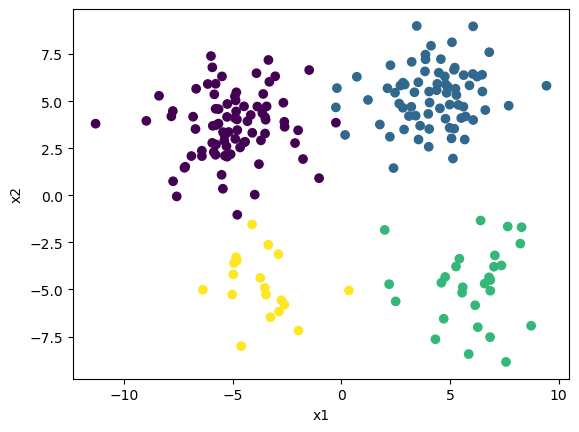

In [62]:
dataset = loadData('cluster_data_dataA_X', 'a')
Y, K = Gussian_mean_shift(dataset, 1.6)
plt.scatter(dataset[0, :], dataset[1, :], c=Y)                
plt.xlabel('x1')
plt.ylabel('x2')
# plt.title('{} data{}'.format(model_name,data))
plt.show()

In [6]:
def plot_1b():
    for model_name in ['Kmeans', 'GMM', 'Mean-shift']:
        plt.figure(figsize=(13,4))
        for i in range(1,4):
            plt.subplot(1,3,i)
            if i==1:data='A' 
            elif i==2:data='B' 
            else:data='C'
            dataset = loadData('cluster_data_data{}_X'.format(data), 'a')
            if model_name == 'Kmeans':
                Y, C = Kmeans(dataset, 4)
            elif model_name == 'GMM':
                Y, mu, Cov_mat, Pi, respon = EM_model(dataset, 4)
            elif model_name == 'Mean-shift':
                Y, K = Gussian_mean_shift(dataset, 1.6)
            plt.scatter(dataset[0, :], dataset[1, :], c=Y)                
            plt.xlabel('x1')
            plt.ylabel('x2')
            plt.title('{} data{}'.format(model_name,data))
        plt.tight_layout()
        plt.show()

In [11]:
def plot_1c(h_list):
    for data_name in ['dataA', 'dataB', 'dataC']:
        plt.figure(figsize=(13,8))
        for i in range(len(h_list)):
            plt.subplot(2,3, i+1)
            dataset = loadData('cluster_data_{}_X'.format(data_name), 'a')
            Y, K = Gussian_mean_shift(dataset, h_list[i])
            plt.scatter(dataset[0, :], dataset[1, :], c=Y)
            plt.xlabel('x1')
            plt.ylabel('x2')
            plt.title('{} with h={}'.format(data_name, h_list[i]))
            plt.tight_layout()
        plt.show()

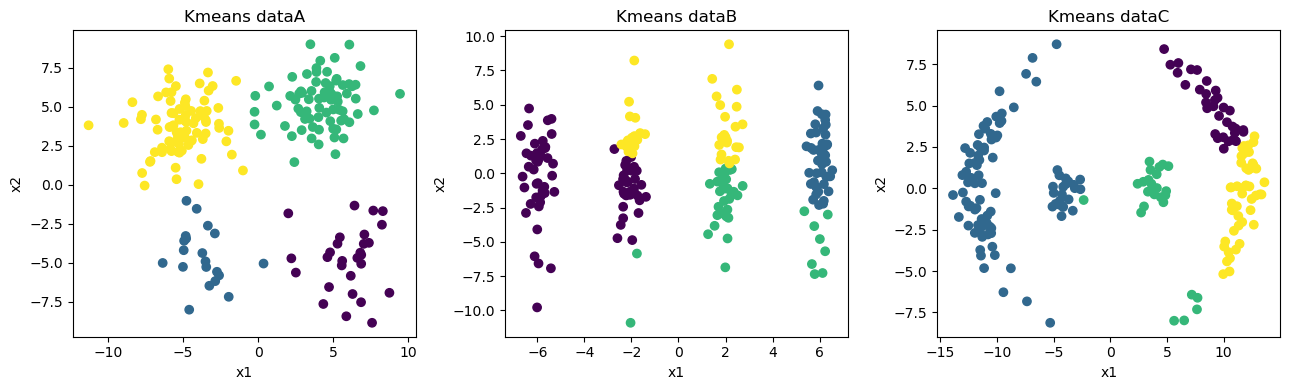

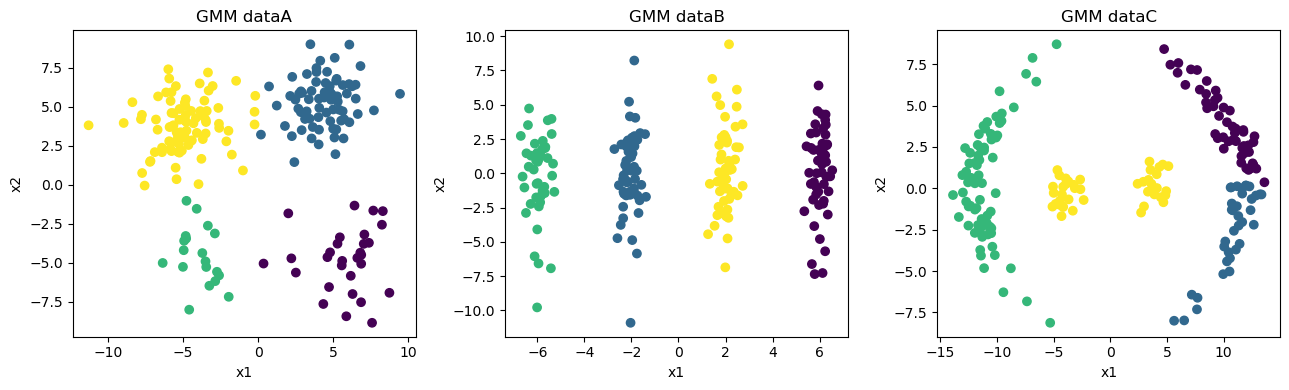

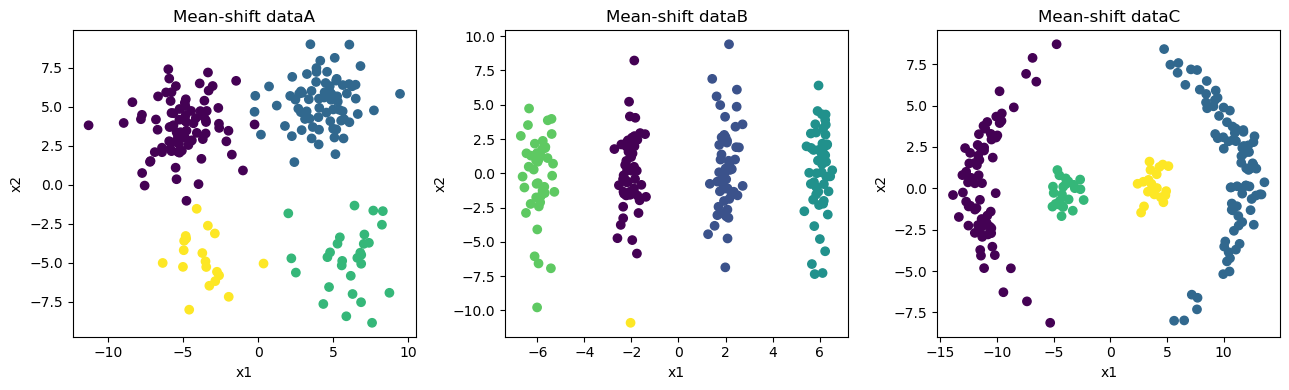

In [705]:
plot_1b()

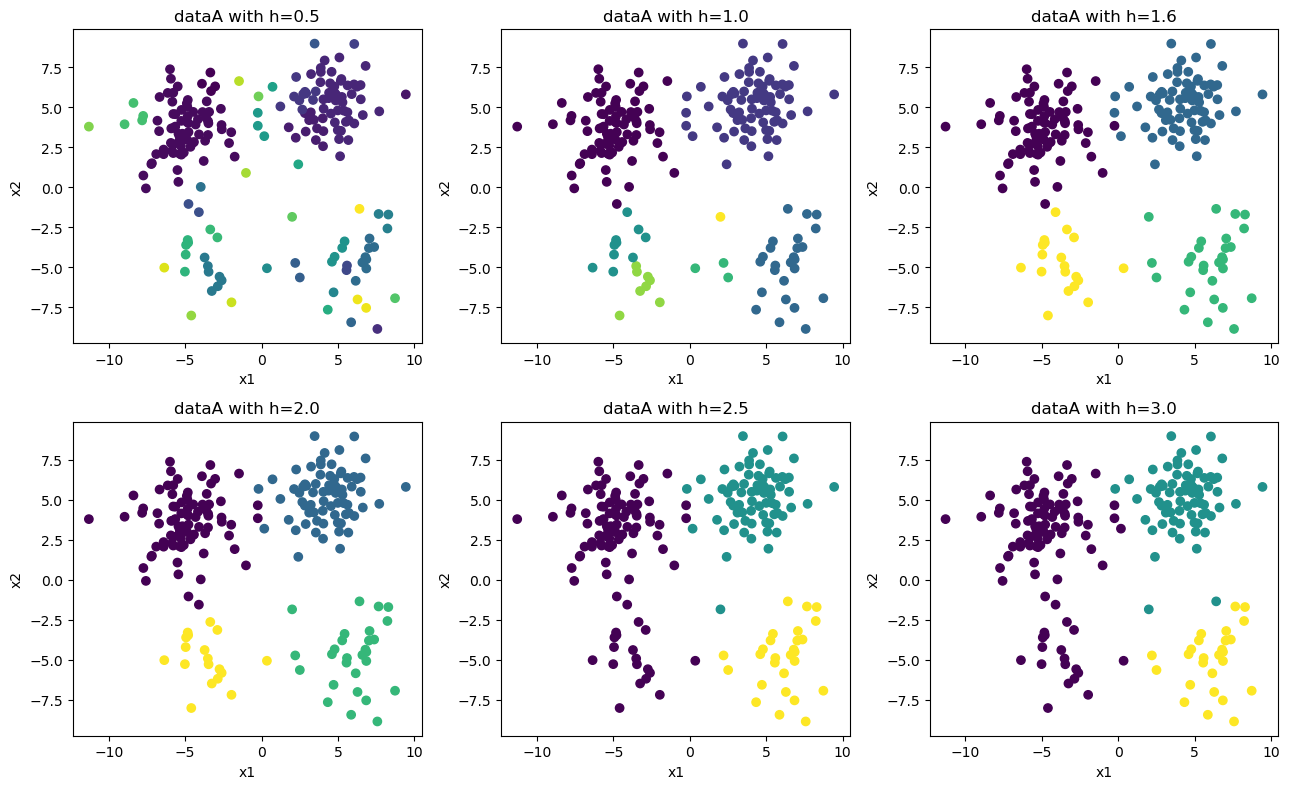

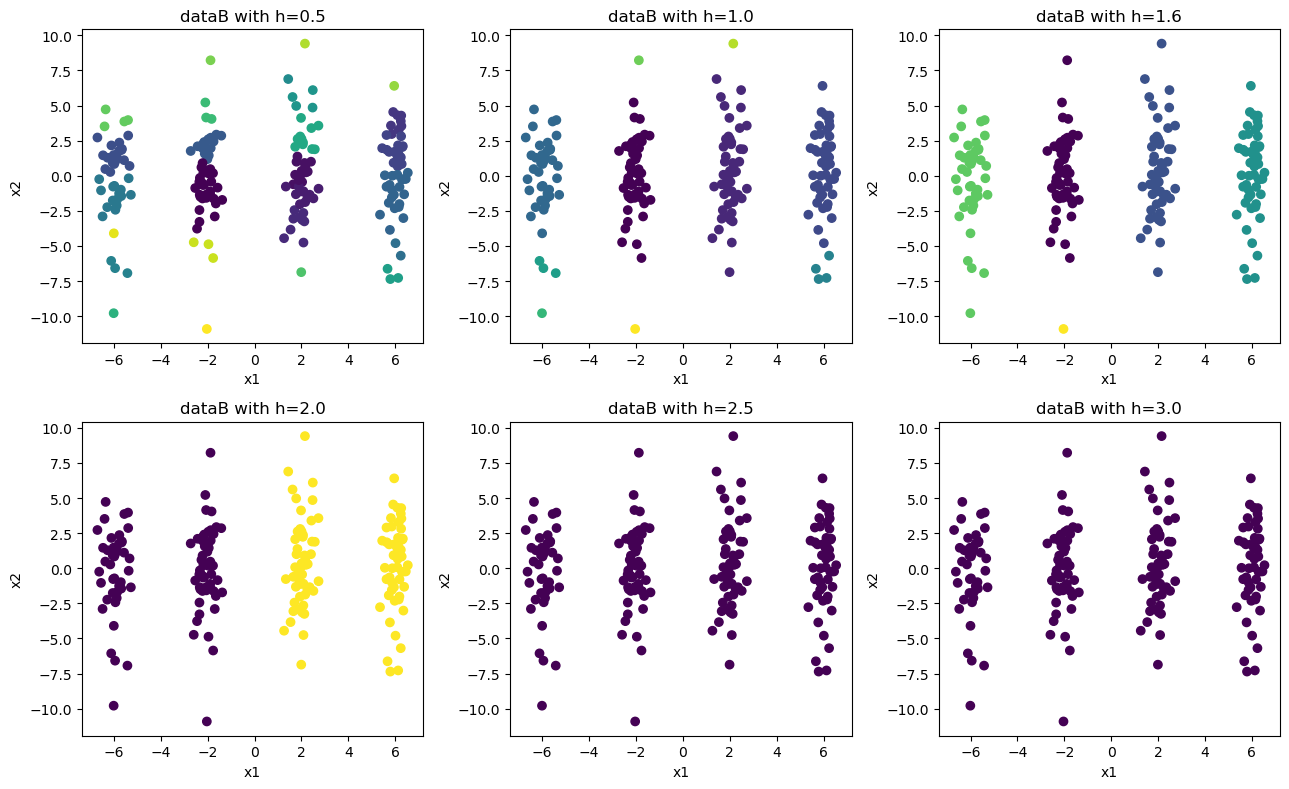

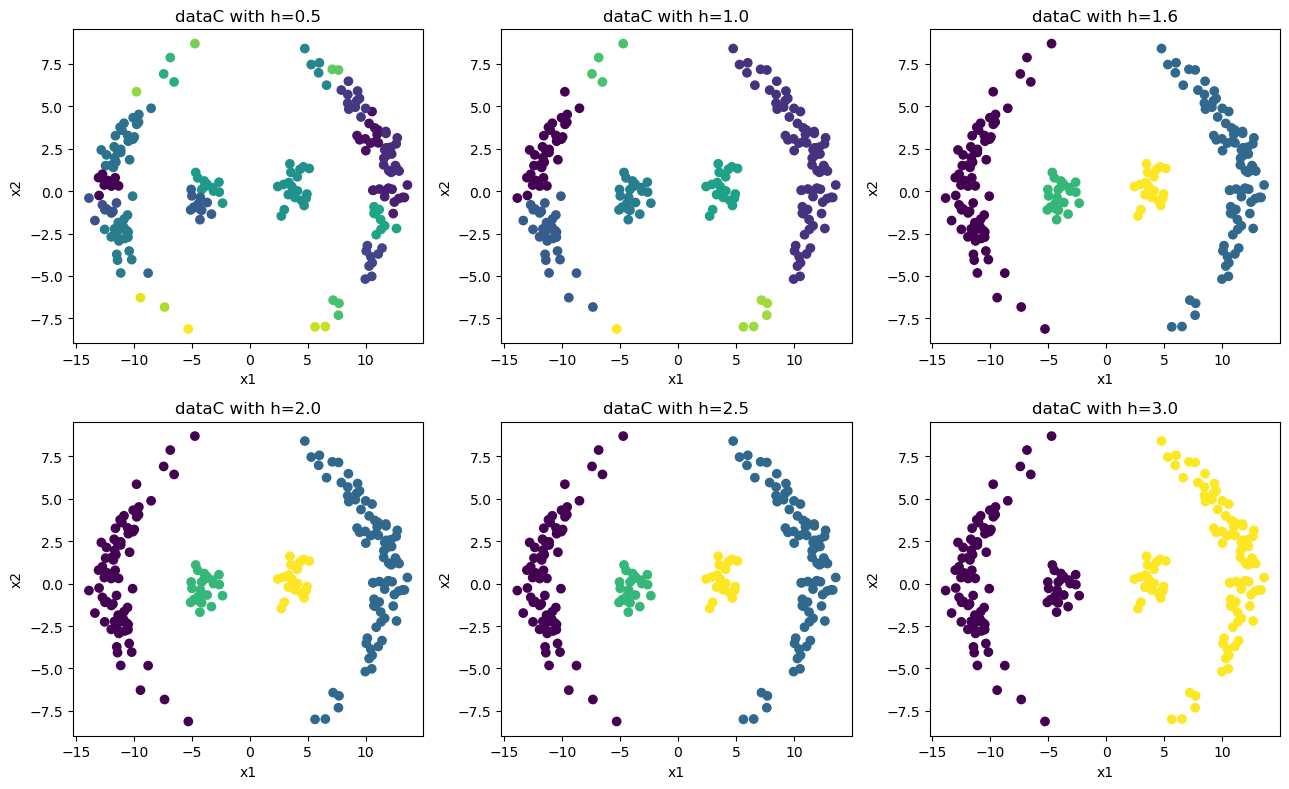

In [12]:
plot_1c([0.5, 1.0, 1.6, 2.0, 2.5, 3.0])

In [23]:
def plot_2a_1(K=[2, 4, 6, 8]):
    img = Image.open('images/12003.jpg')
    dataset, L = loadData('12003', 'b', img=img)
    for model_name in ['Kmeans', 'GMM']:
        for k in K:
            plt.figure(figsize=(12,4))
            plt.subplot(1,3,1)
            plt.title('original')
            plt.imshow(img)
            if model_name == 'Kmeans':
                Y, C = Kmeans(dataset, k)
            elif model_name == 'GMM':
                Y, mu, Cov_mat, Pi, respon = EM_model(dataset, k)
            Y = Y + 1
            segm = pa2.labels2seg(Y,L)
            plt.subplot(1,3,2)
            plt.title('segments')
            plt.imshow(segm)
            csegm = pa2.colorsegms(segm, img)
            plt.subplot(1,3,3)
            plt.title('segments (colored)')
            plt.imshow(csegm)   
            plt.tight_layout()
            plt.show()

In [34]:
def plot_2a_2(H=[0.5, 0.6, 0.8, 0.9]):
    img = Image.open('images/12003.jpg')
    dataset, L = loadData('12003', 'b', img=img)
    for h in H:
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title('original')
        plt.imshow(img)
        Y, K = Gussian_mean_shift(dataset, h)
        Y = Y + 1
        segm = pa2.labels2seg(Y,L)
        plt.subplot(1,3,2)
        plt.title('segments')
        plt.imshow(segm)
        csegm = pa2.colorsegms(segm, img)
        plt.subplot(1,3,3)
        plt.title('segments (colored)')
        plt.imshow(csegm)   
        plt.tight_layout()
        plt.show()


Y, C = Kmeans(dataset, k, scale=1, lbda=0.1)

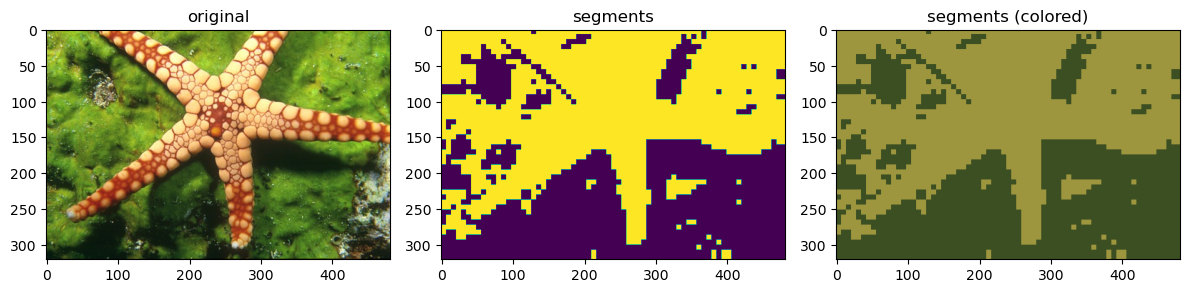

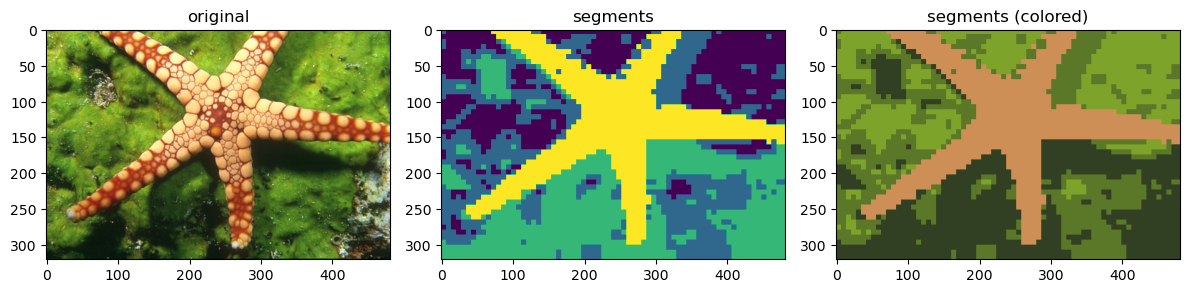

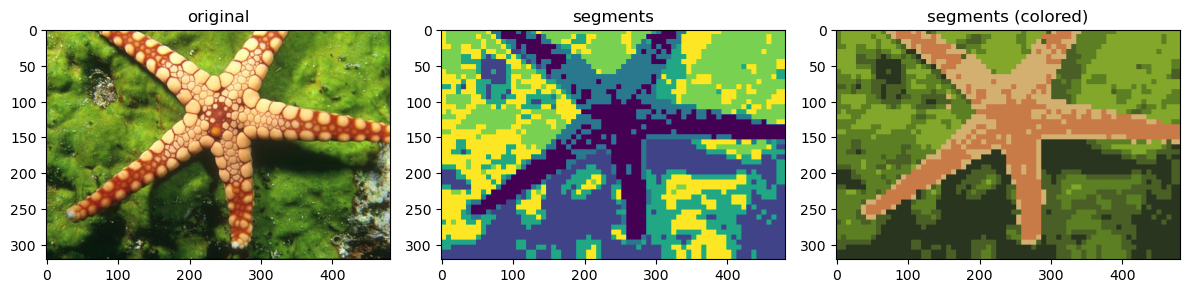

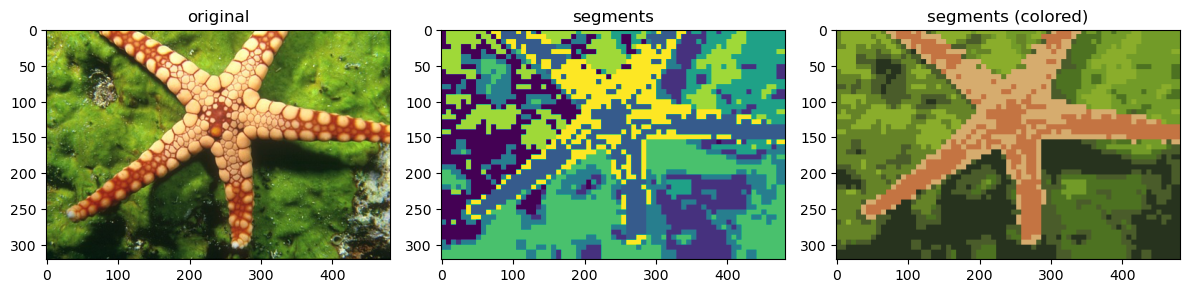

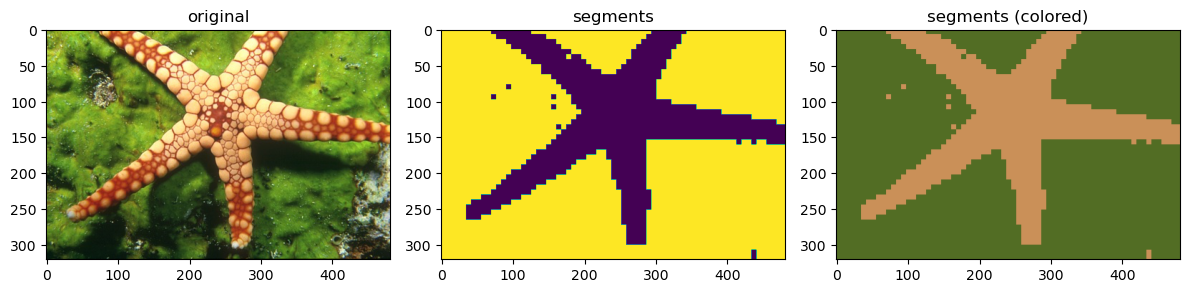

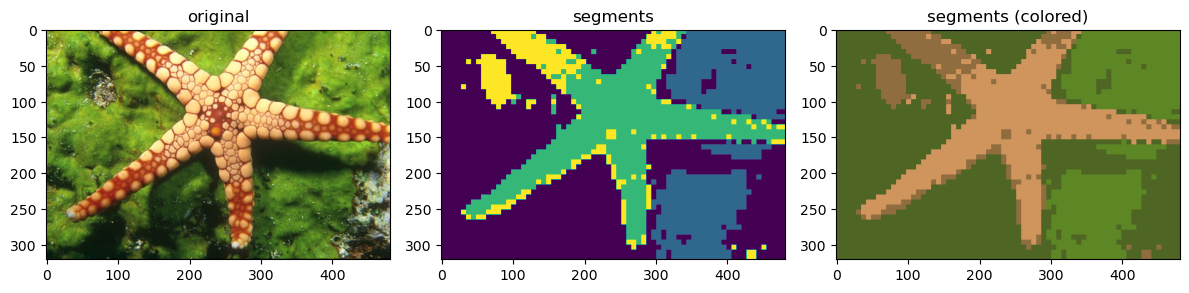

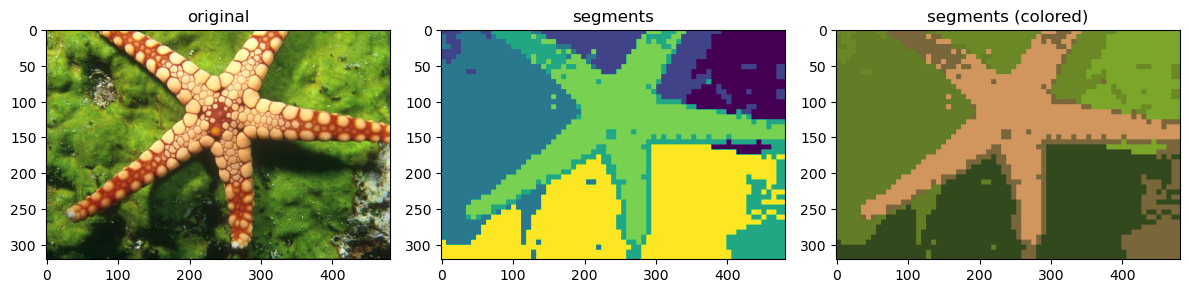

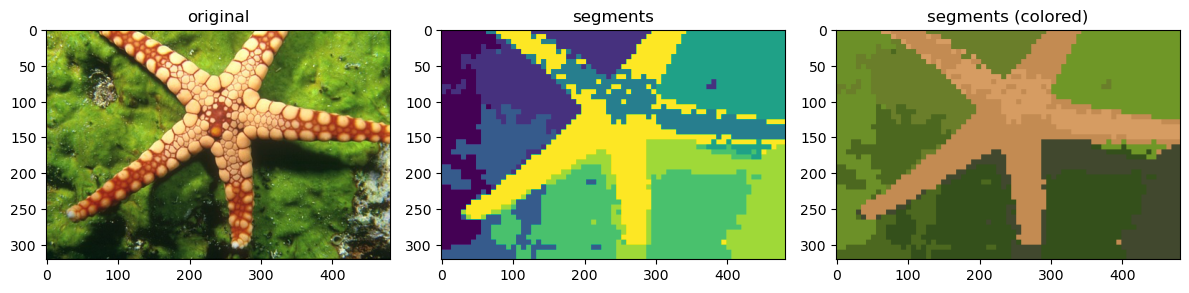

In [26]:
plot_2a_1()

3060
36
37
35
35
38
38
37
37
34
29
25
28
29
18
32
31
26
31
11
37
29
32
39
39
34
33
39
21
18
20
20
48
44
44
45
45
46
46
47
45
46
47
20
20
21
38
38
37
36
38
38
38
37
35
34
29
28
25
35
34
31
34
31
35
38
30
31
37
37
37
39
40
23
19
20
20
21
44
44
43
45
45
45
45
45
46
47
48
20
21
39
38
38
38
38
38
38
36
37
34
32
25
29
35
34
30
28
33
35
34
21
36
38
40
42
40
38
43
16
19
20
19
40
42
43
46
45
45
44
45
46
47
48
21
21
39
38
38
38
38
37
38
37
36
35
30
31
29
35
33
33
28
27
30
31
33
39
43
47
32
40
36
41
45
27
20
19
37
43
44
45
46
45
45
45
45
46
48
21
21
39
38
38
35
33
27
23
28
36
33
26
33
26
35
32
32
22
30
34
32
33
38
42
47
15
41
34
38
40
44
19
20
42
42
45
45
19
19
46
46
45
46
49
21
21
39
39
38
36
32
27
31
33
37
36
28
20
25
34
34
27
29
32
35
32
35
32
37
41
46
40
28
30
39
43
45
18
45
45
47
23
24
18
49
46
46
46
49
21
21
39
38
38
37
35
33
27
27
37
36
33
19
18
27
32
26
33
34
34
30
26
18
33
37
40
39
38
38
38
40
41
43
43
45
45
24
25
24
20
45
45
47
20
21
21
38
36
37
36
34
32
32
29
26
26
25
29
29
23
26
33
35

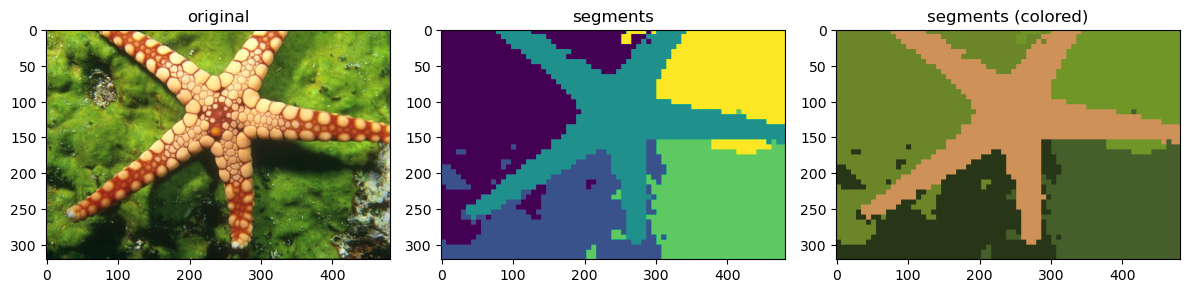

3060
28
27
27
26
28
27
27
27
25
21
18
25
23
20
21
21
22
22
24
28
24
27
30
30
28
28
30
59
59
58
58
60
34
35
35
34
44
39
62
33
35
44
59
59
59
28
28
28
27
28
27
28
27
25
24
21
24
21
25
24
21
23
21
27
29
23
26
29
29
29
30
31
59
58
58
58
59
33
34
32
35
35
34
34
34
37
62
61
58
59
29
28
28
28
28
28
27
26
27
25
23
21
23
25
24
21
22
21
27
27
25
28
30
31
34
31
29
35
58
58
58
58
30
31
32
38
36
33
32
33
37
50
60
58
58
29
28
28
28
28
27
28
27
26
25
21
27
27
25
22
22
22
24
25
22
27
30
35
62
60
31
29
32
44
59
58
58
29
33
34
35
39
33
33
33
34
36
60
58
58
29
28
28
27
26
25
25
25
26
24
22
29
21
25
22
21
22
25
22
21
27
30
33
63
58
32
28
30
31
37
58
58
31
31
41
36
58
58
38
35
34
36
59
58
58
29
29
28
27
26
25
25
27
27
27
21
17
19
24
24
23
24
21
23
21
28
27
29
32
65
31
26
27
30
35
66
58
42
38
61
33
34
58
59
37
35
41
59
58
58
29
28
28
28
27
26
25
27
28
27
25
15
18
20
22
21
22
23
23
22
24
25
27
29
31
30
30
30
30
31
31
33
33
38
37
19
19
49
59
35
33
74
58
58
58
29
28
28
28
27
26
24
24
23
22
21
26
25
18
22
22
25

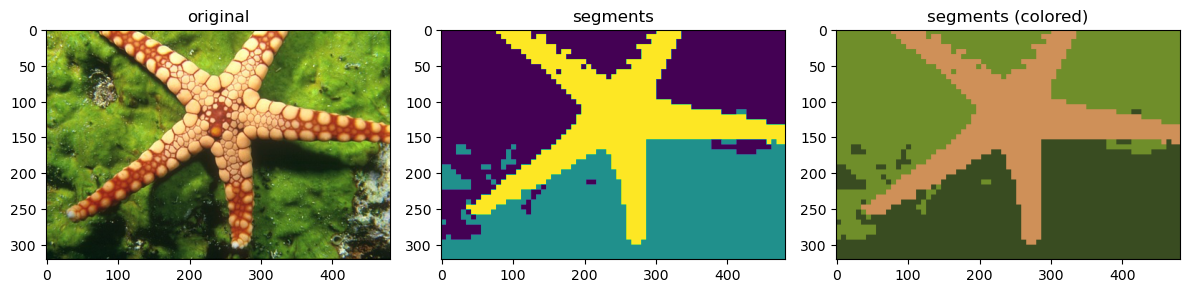

3060
59
59
59
59
60
59
59
59
59
58
57
53
55
57
58
58
57
58
57
53
57
56
47
49
55
55
51
70
74
77
76
68
47
53
51
52
65
64
69
35
54
66
77
77
80
60
59
59
59
60
59
60
59
59
58
58
54
56
59
59
58
59
58
54
50
58
56
53
53
53
50
47
70
75
76
77
71
20
47
42
54
56
52
53
43
61
70
71
78
79
60
60
59
59
60
60
60
59
59
59
58
56
55
59
59
58
58
58
54
55
57
53
50
46
49
45
52
55
73
76
78
76
53
48
37
62
57
23
46
34
62
67
72
79
79
60
60
59
59
59
59
60
59
59
59
58
47
50
59
58
58
58
57
56
58
55
48
53
65
68
42
54
36
63
70
77
75
55
31
46
56
61
36
20
38
47
59
72
79
80
60
60
60
59
58
56
57
57
59
58
55
20
56
59
58
58
57
56
58
58
55
49
45
64
72
21
55
51
46
60
76
77
48
47
64
58
75
77
62
56
44
60
73
79
80
60
60
59
59
58
56
54
58
59
59
57
56
57
59
59
57
56
58
59
58
54
55
52
25
63
45
57
56
50
55
65
75
63
61
68
48
45
74
71
61
56
66
73
79
79
60
60
60
59
59
58
56
58
59
59
58
57
57
57
58
57
58
59
58
58
57
57
55
52
43
48
51
51
51
45
45
40
43
61
55
60
60
49
73
57
43
67
78
80
80
60
59
59
59
59
58
52
54
55
57
55
51
52
57
56
58
59

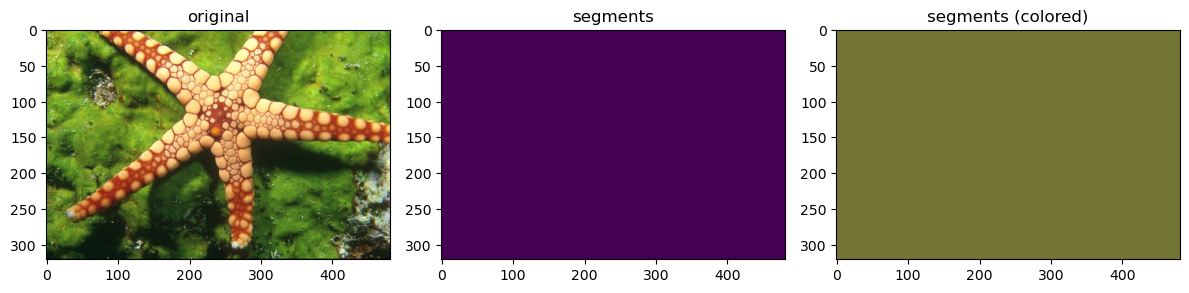

3060
19
19
19
19
19
19
19
19
19
18
18
16
17
18
18
18
18
18
18
16
18
17
13
14
17
17
14
18
19
20
20
18
15
16
16
16
18
18
19
15
17
18
20
20
21
19
19
19
19
19
19
19
19
19
19
18
16
17
19
19
18
19
18
16
14
18
17
16
16
16
14
12
18
19
20
20
19
13
16
12
17
17
17
17
16
18
19
19
20
20
19
19
19
19
19
19
19
19
19
19
18
17
17
19
19
18
18
18
16
17
18
16
15
12
16
12
15
17
19
19
20
19
16
13
13
18
17
15
12
15
18
18
19
20
20
20
19
19
19
19
19
19
19
19
19
18
12
15
19
19
19
18
18
17
18
17
13
16
18
18
12
16
13
18
19
20
19
17
15
16
17
17
15
14
15
16
18
19
20
21
20
19
19
19
19
17
18
18
19
19
17
14
17
19
18
18
18
17
19
18
17
13
15
18
19
14
17
15
12
17
19
20
14
13
18
17
19
20
18
17
16
18
19
20
21
20
20
19
19
18
17
16
19
19
19
18
17
18
19
19
17
17
18
19
18
16
17
15
14
17
12
18
17
14
17
18
19
18
17
18
14
15
19
19
18
17
18
19
20
20
20
19
19
19
19
19
17
18
19
19
19
17
18
18
18
18
18
19
19
18
18
18
17
15
11
14
15
15
15
12
12
15
15
17
16
18
18
16
19
17
15
18
20
21
21
19
19
19
19
19
18
16
16
17
18
17
15
16
18
17
18
19

KeyboardInterrupt: 

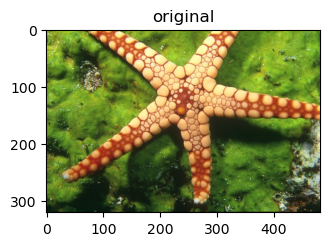

In [63]:
plot_2a_2()